# Database

In [1]:
# Imports
from functions import *
from models import *
from bayespy import nodes
from bayespy.inference import VB
# seed
set_seed(2020)

Using TensorFlow backend.


Load and prepare Breast Cancer database

In [2]:
# Column names
col_names = ["id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst"]
# Reading dataset
dataset = pd.read_csv('../dataset/wdbc.data', header=None, names= col_names)
X = dataset.drop(['id','diagnosis'], axis=1)
y = dataset['diagnosis']

# Constants

In [3]:
# Ammount of samples
n_samples = X.shape[0]
# Observed space dimensionality
dim = X.shape[1]
# Ammount of classes
n_classes = len(y.unique())

# BayesPy

## Model definition

Mean and precision distribucion defined as
$$
\mu \sim \mathcal{N}_{dim}(0,I) \quad \text{and} \quad \Lambda \sim \mathcal{W}(dim,I_{dim}).
$$

Mixture weights follow a Dirichlet distribution
$$
    \pi \sim \text{Symmetric-Dirichlet}\Big(\frac{1}{n\_samples}\Big).
$$

The variable modeling the component assignation follows a categorical distribution as
$$
    Z_n \sim \text{Categorical}(\pi).
$$

In [4]:
# Define a functoin that returns all the variables of the model.
def GaussianMixture(dim, n_components, n_samples):
    Lambda = nodes.Wishart(dim, np.identity(dim), plates=(n_components,))
    mu = nodes.Gaussian(np.zeros(dim), 0.01 * np.identity(dim), plates=(n_components,))
    pi = nodes.Dirichlet(0.01 * np.ones(n_components))
    z = nodes.Categorical(pi, plates=(n_samples,))
    x = nodes.Mixture(z, nodes.Gaussian, mu, Lambda)

    return x, z, pi, mu, Lambda

## Testing Database

We create a mock database with distributions:
$$
\mathcal{N}\Bigg(\begin{pmatrix} 0 \\ 0 \end{pmatrix}, \begin{pmatrix} 0.2 & 0 \\ 0 & 0.2\end{pmatrix} \Bigg) \quad \mathcal{N}\Bigg(\begin{pmatrix} 1 \\ 1 \end{pmatrix}, \begin{pmatrix} 0.1 & 0 \\ 0 & 0.2\end{pmatrix} \Bigg)
$$
$$
\mathcal{N}\Bigg(\begin{pmatrix} 3 \\ 0 \end{pmatrix}, \begin{pmatrix} 0.2 & 0.1 \\ 0.1 & 0.2\end{pmatrix} \Bigg) \quad \mathcal{N}\Bigg(\begin{pmatrix} -2 \\ 0 \end{pmatrix}, \begin{pmatrix} 0.2 & 0 \\ 0 & 0.2\end{pmatrix} \Bigg)
$$

In [5]:
a = np.random.multivariate_normal([0, 0], [[0.2, 0], [0, 0.2]], size=100)
b = np.random.multivariate_normal([1, 1], [[0.1, 0], [0, 0.2]], size=100)
c = np.random.multivariate_normal([3, 0], [[0.2, 0.1], [0.1, 0.2]], size=60)
d = np.random.multivariate_normal([-2, 0], [[0.2, 0], [0, 0.2]], size=80)
data = np.vstack([a, b, c, d])

Create the mixture variables

In [6]:
x, z, pi, mu, Lambda = GaussianMixture(dim = data.shape[1], 
                                       n_components = 4, 
                                       n_samples = data.shape[0])

Observe the variables

In [7]:
x.observe(data)

Create the inference object

In [8]:
Q = VB(x, mu, z, Lambda, pi)

Initialize `z` using random values as letting the default initialization (prior) leads to 4 simmilar normal distributions.

In [9]:
z.initialize_from_random()

Start learning

In [10]:
Q.update(repeat=200)

Iteration 1: loglike=-1.091043e+03 (0.014 seconds)
Iteration 2: loglike=-1.033300e+03 (0.007 seconds)
Iteration 3: loglike=-1.024515e+03 (0.006 seconds)
Iteration 4: loglike=-1.016438e+03 (0.006 seconds)
Iteration 5: loglike=-1.007614e+03 (0.006 seconds)
Iteration 6: loglike=-9.946992e+02 (0.006 seconds)
Iteration 7: loglike=-9.792446e+02 (0.005 seconds)
Iteration 8: loglike=-9.696564e+02 (0.006 seconds)
Iteration 9: loglike=-9.631894e+02 (0.006 seconds)
Iteration 10: loglike=-9.581776e+02 (0.006 seconds)
Iteration 11: loglike=-9.538887e+02 (0.006 seconds)
Iteration 12: loglike=-9.492101e+02 (0.006 seconds)
Iteration 13: loglike=-9.427131e+02 (0.006 seconds)
Iteration 14: loglike=-9.328183e+02 (0.006 seconds)
Iteration 15: loglike=-9.221538e+02 (0.006 seconds)
Iteration 16: loglike=-9.190234e+02 (0.006 seconds)
Iteration 17: loglike=-9.175665e+02 (0.006 seconds)
Iteration 18: loglike=-9.153723e+02 (0.006 seconds)
Iteration 19: loglike=-9.120490e+02 (0.006 seconds)
Iteration 20: loglike

Plot results using `BayesPy` functions.

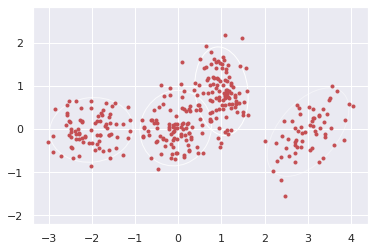

In [11]:
import bayespy.plot as bpplt
bpplt.gaussian_mixture_2d(x, alpha=pi)
bpplt.pyplot.show()

We may get the posterior values printing each variable

In [12]:
print(mu)

 ~ Gaussian(mu, Cov)
  mu = 
[[-0.0568914   0.02390107]
 [ 1.00267558  0.87919499]
 [-2.01174192 -0.01762713]
 [ 3.00657759 -0.06899422]]
  Cov = 
[[[ 0.00178164  0.00012891]
  [ 0.00012891  0.0019966 ]]

 [[ 0.00092164 -0.00019222]
  [-0.00019222  0.00253632]]

 [[ 0.00291598  0.00013761]
  [ 0.00013761  0.00174685]]

 [[ 0.00373347  0.00209349]
  [ 0.00209349  0.00437662]]]



## Breast Cancer Diagnosys

Define the new variables

In [13]:
x, z, pi, mu, Lambda = GaussianMixture(dim = X.shape[1], 
                                       n_components = len(y.unique()), 
                                       n_samples = X.shape[0])

Observe the given dataset, `Pandas' dataframe` can't be used. They raise a dimensionality error.

In [14]:
x.observe(X.to_numpy())

Create the inference object.

In [15]:
Q = VB(x, mu, z, Lambda, pi)

Initialize `z` using random values as letting the default initialization (prior) leads to 4 simmilar normal distributions.

In [16]:
z.initialize_from_random()

Start learning.

In [17]:
Q.update(repeat=1000)

Iteration 1: loglike=-1.547595e+04 (0.049 seconds)
Iteration 2: loglike=-2.746159e+03 (0.044 seconds)
Iteration 3: loglike=-2.382180e+03 (0.044 seconds)
Iteration 4: loglike=-2.240299e+03 (0.046 seconds)
Iteration 5: loglike=-2.075352e+03 (0.042 seconds)
Iteration 6: loglike=-1.943905e+03 (0.045 seconds)
Iteration 7: loglike=-1.825683e+03 (0.043 seconds)
Iteration 8: loglike=-1.683301e+03 (0.043 seconds)
Iteration 9: loglike=-1.555149e+03 (0.046 seconds)
Iteration 10: loglike=-1.515704e+03 (0.044 seconds)
Iteration 11: loglike=-1.500252e+03 (0.049 seconds)
Iteration 12: loglike=-1.481314e+03 (0.059 seconds)
Iteration 13: loglike=-1.455908e+03 (0.058 seconds)
Iteration 14: loglike=-1.426566e+03 (0.062 seconds)
Iteration 15: loglike=-1.414406e+03 (0.064 seconds)
Iteration 16: loglike=-1.405696e+03 (0.047 seconds)
Iteration 17: loglike=-1.401614e+03 (0.046 seconds)
Iteration 18: loglike=-1.399670e+03 (0.045 seconds)
Iteration 19: loglike=-1.397998e+03 (0.044 seconds)
Iteration 20: loglike

Iteration 160: loglike=-1.103579e+03 (0.066 seconds)
Iteration 161: loglike=-1.103486e+03 (0.056 seconds)
Iteration 162: loglike=-1.103392e+03 (0.046 seconds)
Iteration 163: loglike=-1.103299e+03 (0.053 seconds)
Iteration 164: loglike=-1.103207e+03 (0.050 seconds)
Iteration 165: loglike=-1.103114e+03 (0.051 seconds)
Iteration 166: loglike=-1.103022e+03 (0.052 seconds)
Iteration 167: loglike=-1.102931e+03 (0.047 seconds)
Iteration 168: loglike=-1.102839e+03 (0.054 seconds)
Iteration 169: loglike=-1.102748e+03 (0.060 seconds)
Iteration 170: loglike=-1.102658e+03 (0.066 seconds)
Iteration 171: loglike=-1.102567e+03 (0.062 seconds)
Iteration 172: loglike=-1.102477e+03 (0.051 seconds)
Iteration 173: loglike=-1.102387e+03 (0.053 seconds)
Iteration 174: loglike=-1.102297e+03 (0.054 seconds)
Iteration 175: loglike=-1.102208e+03 (0.049 seconds)
Iteration 176: loglike=-1.102119e+03 (0.044 seconds)
Iteration 177: loglike=-1.102030e+03 (0.045 seconds)
Iteration 178: loglike=-1.101942e+03 (0.052 se

Iteration 315: loglike=-1.091702e+03 (0.050 seconds)
Iteration 316: loglike=-1.091639e+03 (0.049 seconds)
Iteration 317: loglike=-1.091576e+03 (0.046 seconds)
Iteration 318: loglike=-1.091514e+03 (0.047 seconds)
Iteration 319: loglike=-1.091451e+03 (0.047 seconds)
Iteration 320: loglike=-1.091389e+03 (0.048 seconds)
Iteration 321: loglike=-1.091327e+03 (0.050 seconds)
Iteration 322: loglike=-1.091264e+03 (0.044 seconds)
Iteration 323: loglike=-1.091203e+03 (0.053 seconds)
Iteration 324: loglike=-1.091141e+03 (0.053 seconds)
Iteration 325: loglike=-1.091079e+03 (0.047 seconds)
Iteration 326: loglike=-1.091018e+03 (0.044 seconds)
Iteration 327: loglike=-1.090956e+03 (0.045 seconds)
Iteration 328: loglike=-1.090895e+03 (0.044 seconds)
Iteration 329: loglike=-1.090834e+03 (0.047 seconds)
Iteration 330: loglike=-1.090773e+03 (0.046 seconds)
Iteration 331: loglike=-1.090713e+03 (0.047 seconds)
Iteration 332: loglike=-1.090652e+03 (0.053 seconds)
Iteration 333: loglike=-1.090592e+03 (0.050 se

Iteration 473: loglike=-1.083595e+03 (0.045 seconds)
Iteration 474: loglike=-1.083555e+03 (0.044 seconds)
Iteration 475: loglike=-1.083515e+03 (0.045 seconds)
Iteration 476: loglike=-1.083476e+03 (0.044 seconds)
Iteration 477: loglike=-1.083436e+03 (0.046 seconds)
Iteration 478: loglike=-1.083397e+03 (0.046 seconds)
Iteration 479: loglike=-1.083357e+03 (0.045 seconds)
Iteration 480: loglike=-1.083318e+03 (0.043 seconds)
Iteration 481: loglike=-1.083279e+03 (0.045 seconds)
Iteration 482: loglike=-1.083240e+03 (0.043 seconds)
Iteration 483: loglike=-1.083201e+03 (0.048 seconds)
Iteration 484: loglike=-1.083162e+03 (0.044 seconds)
Iteration 485: loglike=-1.083124e+03 (0.044 seconds)
Iteration 486: loglike=-1.083085e+03 (0.044 seconds)
Iteration 487: loglike=-1.083047e+03 (0.044 seconds)
Iteration 488: loglike=-1.083009e+03 (0.046 seconds)
Iteration 489: loglike=-1.082971e+03 (0.044 seconds)
Iteration 490: loglike=-1.082933e+03 (0.047 seconds)
Iteration 491: loglike=-1.082895e+03 (0.049 se

Iteration 630: loglike=-1.078805e+03 (0.052 seconds)
Iteration 631: loglike=-1.078783e+03 (0.050 seconds)
Iteration 632: loglike=-1.078761e+03 (0.051 seconds)
Iteration 633: loglike=-1.078740e+03 (0.050 seconds)
Iteration 634: loglike=-1.078718e+03 (0.052 seconds)
Iteration 635: loglike=-1.078696e+03 (0.054 seconds)
Iteration 636: loglike=-1.078675e+03 (0.060 seconds)
Iteration 637: loglike=-1.078654e+03 (0.057 seconds)
Iteration 638: loglike=-1.078632e+03 (0.064 seconds)
Iteration 639: loglike=-1.078611e+03 (0.053 seconds)
Iteration 640: loglike=-1.078590e+03 (0.050 seconds)
Iteration 641: loglike=-1.078569e+03 (0.049 seconds)
Iteration 642: loglike=-1.078548e+03 (0.048 seconds)
Iteration 643: loglike=-1.078527e+03 (0.050 seconds)
Iteration 644: loglike=-1.078507e+03 (0.049 seconds)
Iteration 645: loglike=-1.078486e+03 (0.049 seconds)
Iteration 646: loglike=-1.078465e+03 (0.049 seconds)
Iteration 647: loglike=-1.078445e+03 (0.048 seconds)
Iteration 648: loglike=-1.078425e+03 (0.052 se

Again, we might print the posterior value printing the variables.

In [18]:
print(mu)

 ~ Gaussian(mu, Cov)
  mu = 
[[ 8.27676895e+00  1.68592463e+01  5.17310855e+01  8.12195827e+01
   9.26492303e-02  5.93356768e-02 -1.28381130e-03 -4.81899127e-03
   1.74428065e-01  6.62954166e-02  1.24858394e-01  1.31298723e+00
   8.46073177e-01 -7.28611028e+00  8.20651712e-03  1.93945361e-02
   2.22335279e-02  7.87821469e-03  2.22125643e-02  3.97057189e-03
   8.44511667e+00  2.24518622e+01  5.30994552e+01 -7.09927826e+00
   1.27393043e-01  1.41749856e-01  8.33386409e-02  3.13021904e-02
   2.71343441e-01  8.31134066e-02]
 [ 8.77857933e+00 -6.28201121e+00  2.05596741e+01 -6.00798102e-01
  -9.08389187e-02 -7.08035681e-01 -1.18877069e+00 -3.98571170e-01
  -2.64314837e-01  3.33582243e-03  6.41646833e-01 -3.99427317e+00
   1.21385991e+01 -2.05384195e+00 -5.09111348e-02 -3.41962669e-01
  -3.90845058e-01 -1.95026401e-02  2.26104869e-03 -1.94695228e-02
   1.34959803e+01  5.70203131e+00  2.10632716e+01 -5.42037924e-01
  -9.86253218e-02 -1.46940859e+00 -1.93140139e+00 -3.29505479e-01
  -2.7455520

We might generate a posterior sample using `random()`.

In [28]:
print(x.random())

[[ 0.1099873   0.0683801   0.18593033 ... -0.15749125  0.25409106
  -0.30969548]
 [-0.02087631 -0.09516944 -0.1978421  ...  0.05496869 -0.30955114
   0.23605873]
 [-0.02564227 -0.26974892 -0.21759923 ...  0.19614123 -0.10641323
  -0.0042563 ]
 ...
 [ 0.02017709  0.18487487 -0.1352647  ...  0.23942943 -0.24678171
  -0.02383657]
 [-0.07262186  0.02452388  0.02889085 ...  0.22335181 -0.06795671
   0.2922284 ]
 [-0.00142964 -0.1026804  -0.11677703 ... -0.38422462 -0.13747797
  -0.17176839]]
